In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
from pathlib import Path
from tqdm import tqdm

from data_loader_pytorch import DataGenerator
from models_pytorch import VAEmodel, LSTMModel
from trainers_pytorch import VAETrainer
from utils import process_config, create_dirs

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # keep GPU ordering consistent
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
# load VAE model
config = process_config('config.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir'], config['checkpoint_dir_lstm']])
# create your data generator
data = DataGenerator(config)

In [5]:
# create a VAE model and load the latest checkpoint
vae_model = VAEmodel(config).to(device)
vae_model.eval()
vae_trainer = VAETrainer(vae_model, data, config)

checkpoint_dir = config['checkpoint_dir']
checkpoint_files = [f for f in Path(checkpoint_dir).iterdir() if f.name.startswith('vae_checkpoint') and f.name.endswith('.pth')]
if not checkpoint_files:
    raise FileNotFoundError(f"No VAE checkpoint found in {checkpoint_dir}")
latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.name.split('_')[-1].split('.')[0]))
vae_trainer.load_model(latest_checkpoint)
vae_model.eval()


Model loaded from experiments/local-results/WESAD/batch-32/WESAD-48-12-6-fixedSigma-0.1/checkpoint/vae_checkpoint_epoch_10.pth


VAEmodel(
  (enc_conv1): Conv2d(1, 32, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv2): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
  (enc_conv4): Conv2d(128, 512, kernel_size=(6, 14), stride=(1, 1))
  (enc_fc): Linear(in_features=512, out_features=24, bias=True)
  (enc_fc_mean): Linear(in_features=24, out_features=6, bias=True)
  (enc_fc_std): Linear(in_features=24, out_features=6, bias=True)
  (dec_fc): Linear(in_features=6, out_features=512, bias=True)
  (dec_conv1): Conv2d(512, 768, kernel_size=(1, 1), stride=(1, 1))
  (dec_conv2): Conv2d(256, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_conv3): Conv2d(128, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_conv4): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
  (dec_out): Conv2d(16, 14, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
)

In [6]:
# load LSTM model
lstm_model = LSTMModel(config).to(device)
lstm_checkpoint_path = Path(config['checkpoint_dir_lstm']) / 'lstm_model.pth'
if not lstm_checkpoint_path.is_file():
    raise FileNotFoundError(f"Expected LSTM checkpoint at {lstm_checkpoint_path}")
lstm_state_dict = torch.load(lstm_checkpoint_path, map_location=device)
lstm_model.load_state_dict(lstm_state_dict)
lstm_model.eval()
print(f"Loaded LSTM checkpoint: {lstm_checkpoint_path.name}")

Loaded LSTM checkpoint: lstm_model.pth


In [7]:
# load normalised time series
data_dir = Path('../data/')

train_df = pd.read_csv(data_dir / 'train.csv')
train_df = train_df.drop(columns=['label', 'subject_id'])
train_m = train_df.mean()
train_std = train_df.std()

val_df_with_anomaly = pd.read_csv(data_dir / 'val_with_anomaly.csv')
val_subjects_with_anomaly = val_df_with_anomaly.pop('subject_id')
val_label_with_anomaly = val_df_with_anomaly.pop('label')

test_df = pd.read_csv(data_dir / 'test.csv')
test_subjects = test_df.pop('subject_id')
test_label = test_df.pop('label')
test_df_normalized = (test_df - train_m) / train_std

result = {}
result['test'] = test_df_normalized.to_numpy()
result['idx_anomaly_test'] = test_label[test_label == 1].index.to_numpy()
result['train_m'] = train_m.values[0]
result['train_std'] = train_std.values[0]
result['t_unit'] = '0.25 sec'
result['t_test'] = np.arange(len(test_df_normalized))

test_windows, test_seq = data.test_set_vae['data'], data.test_set_lstm['data']
print(test_windows.shape)
print(test_seq.shape)

(17894, 48, 14)
(16838, 12, 48, 14)


In [8]:

# Evaluate ELBO and LSTM prediction error on the validation set
# evaluate some anomaly detection metrics
def evaluate_vae_anomaly_metrics_for_a_window(test_win):
    window_tensor = torch.from_numpy(test_win).float().unsqueeze(0).to(device)
    with torch.no_grad():
        recon_win, latent_mean, latent_std = vae_model(window_tensor)
    recon_win = recon_win.squeeze(0).cpu().numpy()
    latent_mean = latent_mean.squeeze(0).cpu().numpy()
    latent_std = latent_std.squeeze(0).cpu().numpy()

    test_vae_recons_error = np.sum(np.square(recon_win - test_win))
    safe_std = np.clip(latent_std, 1e-9, None)
    test_vae_kl = 0.5 * (
        np.sum(np.square(latent_mean))
        + np.sum(np.square(safe_std))
        - np.sum(np.log(np.square(safe_std)))
        - config['code_size']
    )

    sigma2 = vae_model.get_sigma2().item()
    input_dims = vae_model.input_dims
    sigma_regularisor = input_dims / 2.0 * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error / sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo


def evaluate_lstm_anomaly_metric_for_a_seq(test_seq):
    seq_tensor = torch.from_numpy(test_seq).float().to(device)
    seq_tensor = seq_tensor.view(config['l_seq'], config['l_win'], config['n_channel'])

    with torch.no_grad():
        vae_mean, _ = vae_model.encode(seq_tensor)
        input_embeddings = vae_mean[:-1].unsqueeze(0)
        lstm_pred = lstm_model(input_embeddings).squeeze(0)
        embedding_error = torch.sum((vae_mean[1:] - lstm_pred) ** 2).item()

        reconstructed = vae_model.decode(lstm_pred)
        reconstructed = reconstructed.squeeze(-1)
        target_windows = seq_tensor[1:].squeeze(-1)
        reconstruction_error = torch.sum((reconstructed - target_windows) ** 2).item()

    return reconstruction_error, embedding_error

n_val_vae = data.val_set_vae_with_anomaly['data'].shape[0]
n_val_lstm = data.val_set_lstm_with_anomaly['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in tqdm(range(n_val_vae)):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae_with_anomaly['data'][i])

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
for i in tqdm(range(n_val_lstm)):
    val_lstm_recons_error[i], val_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.val_set_lstm_with_anomaly['data'][i])


100%|██████████| 16690/16690 [00:25<00:00, 663.06it/s]


In [9]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=False):
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+'reconstruction_error_histogram.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
#     print("Median: {}".format(np.median(test_anomaly_list)))
#     print("Mean: {}".format(np.mean(test_anomaly_list)))
#     print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

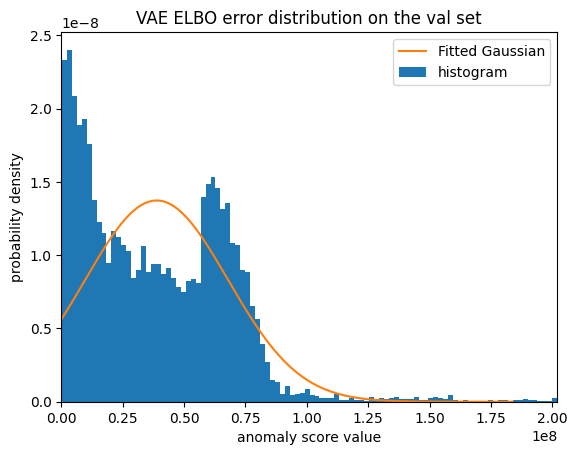

25% percentile: 12358125.413940705
75% percentile: 61559406.415738866
These windows scored the top 1% of anomaly metric (131160649.99176434): 
[ 9418  9419  9420  9421 15158 15159 15160 15161 15162 15163 15164 15165
 15166 15167 15168 15169 15170 15171 15172 15173 15174 15175 15176 15177
 15178 15179 15180 15181 15182 15183 15184 15185 15186 15187 15188 15189
 15190 15191 15192 15193 15194 15195 15196 15197 15198 15199 15200 15201
 15202 15203 15236 15237 15238 15239 15240 15241 15242 15243 15244 15245
 15246 15247 15248 15249 15250 15251 15252 15253 15254 15255 15256 15257
 15258 15259 15260 15261 15534 15535 15536 15537 15538 15539 15540 15541
 15542 15543 15544 15545 15546 15915 15916 15917 15918 15919 15920 15921
 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932 15933
 15934 15935 15936 15937 15938 15939 15940 15941 15942 15943 15944 15945
 15946 15947 16011 16012 16013 16014 16015 16016 16017 16018 16019 16020
 16021 16022 16023 16024 16025 16026 16027 16028 16029

In [10]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

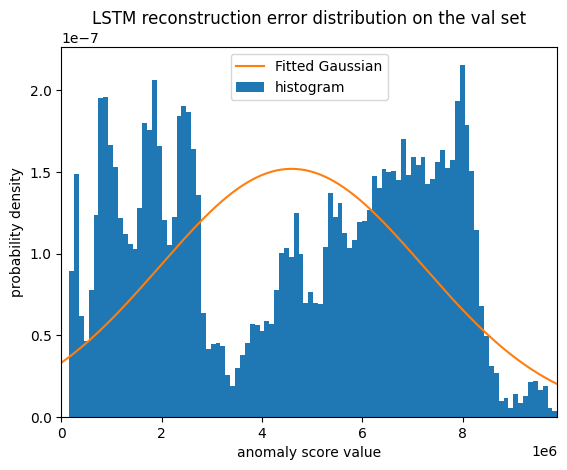

25% percentile: 2015319.21875
75% percentile: 6959009.125
These windows scored the top 1% of anomaly metric (9186834.750000004): 
[ 8461  8462  8463  8464  8471  8636  8637  8638  8639  8646  8811  8812
  8813  8814  8821  8986  8987  8988  8989  8996  9161  9162  9163  9164
  9171  9336  9337  9338  9339  9346  9510  9511  9512  9513  9520  9684
  9685  9686  9694  9858  9859  9860  9868 10032 10033 10034 10042 10206
 10207 10208 10216 10380 10381 10382 10390 10554 10555 10556 10564 10729
 10730 10738 10902 10903 10904 11076 11077 11078 11250 11251 11252 11424
 11425 11426 11598 11599 11600 11772 11773 11774 11946 11947 11948 12120
 12121 12122 12294 12295 12296 12468 12469 12470 12643 12644 12817 12818
 12991 12992 13165 13166 13338 13339 13340 13512 13513 13514 13686 13687
 13688 13860 13861 13862 14034 14035 14036 14208 14209 14210 14382 14383
 14384 14556 14557 14558 14730 14731 14732 14904 14905 14906 15078 15079
 15080 15251 15252 15253 15254 15425 15426 15427 15428 15599 15600 

In [11]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m, lstm_recons_std = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [12]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
for i in tqdm(range(n_test_lstm)):
    test_lstm_recons_error[i], test_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

100%|██████████| 16838/16838 [00:26<00:00, 640.33it/s]

All windows' reconstruction error is computed.
The total number of windows is 16838


25% percentile: 1915615.0625
75% percentile: 5736081.0
These windows scored the top 1% of anomaly metric (9411433.53): 
[ 8445  8446  8447  8623  8624  8625  8801  8802  8803  8980  8981  9157
  9158  9159  9335  9336  9337  9338  9514  9515  9692  9693  9694  9869
  9870  9871  9872 10047 10048 10049 10225 10226 10227 10403 10404 10405
 10581 10582 10583 10759 10760 10761 10937 10938 10939 10940 11115 11116
 11117 11118 11292 11293 11294 11295 11296 11471 11472 11473 11474 11649
 11650 11651 11652 11828 11829 11830 12005 12006 12007 12008 12183 12184
 12185 12186 12360 12361 12362 12363 12364 12539 12540 12541 12542 12716
 12717 12718 12719 12720 12894 12895 12896 12897 12898 13072 13073 13074
 13075 13076 13250 13251 13252 13253 13254 13428 13429 13430 13431 13432
 13606 13607 13608 13609 13610 13611 13784 13785 13786 13787 13788 13789
 13962 13963 13964 13965 14140 14141 14142 14143 14318 14319 14320 14321
 14495 14496 14497 14498 14672 14673 14674 14675 14849 14850 14851 14852
 148

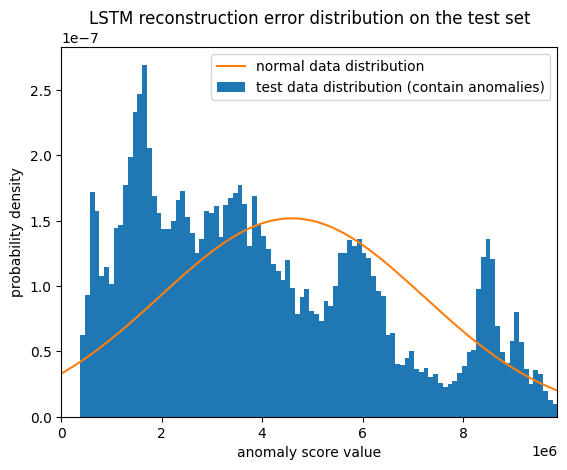

In [13]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m, std=lstm_recons_std, xlim=None, saveplot=True)

In [14]:
idx_anomaly_val = val_label_with_anomaly[val_label_with_anomaly == 1].index.to_numpy()
val_anomaly_index_lstm = []
val_labels_lstm = np.zeros(n_val_lstm)
for i in tqdm(range(len(idx_anomaly_val))):
    idx_start = idx_anomaly_val[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_val[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_val_lstm:
        idx_end = n_val_lstm
    val_anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    val_labels_lstm[idx_start:idx_end] = 1

print(val_labels_lstm.shape)

100%|██████████| 5444/5444 [00:00<00:00, 272948.63it/s]

(16690,)


In [15]:
idx_anomaly_test = result['idx_anomaly_test']
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in tqdm(range(len(idx_anomaly_test))):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_test[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

100%|██████████| 5584/5584 [00:00<00:00, 279077.17it/s]

(16838,)


In [16]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    idx_error = np.flatnonzero(test_anomaly_metric > threshold)
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    return idx_error

In [17]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    idx_detected_anomaly_set = set(idx_detected_anomaly)
    idx_detected_anomaly_extended = set(idx_detected_anomaly)
    
    # anomaly_index는 이상 구간(리스트의 리스트)이라고 가정
    for anomaly_win in anomaly_index:
        # 현재 이상 구간(anomaly_win)이 기존 탐지에 포함되었는지 확인
        # set intersection이 빠름
        if idx_detected_anomaly_set.intersection(anomaly_win):
            # 포함되었다면 해당 구간 전체를 확장된 set에 추가
            idx_detected_anomaly_extended.update(anomaly_win)

    # numpy로 변환 후 정렬
    return np.sort(np.array(list(idx_detected_anomaly_extended), dtype=int))

In [18]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):  
    detected_labels = test_labels[idx_detected_anomaly]
    n_TP = np.sum(detected_labels == 1)
    n_FP = np.sum(detected_labels == 0)
    n_FN = np.sum(test_labels == 1) - n_TP
    
    return n_TP, n_FP, n_FN

In [19]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP, n_FP, n_FN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    precision = n_TP / (n_TP + n_FP) if (n_TP + n_FP) > 0 else 1.0
    recall = n_TP / (n_TP + n_FN) if (n_TP + n_FN) > 0 else 0.0
    F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, F1, n_TP, n_FP, n_FN

In [20]:
n_threshold = 200
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
i = 0
# Create threshold list using only the validation set reconstruction error / DO NOT USE TEST SET
threshold_list = np.linspace(np.amin(val_lstm_recons_error), np.amax(val_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in tqdm(threshold_list):
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(val_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           val_anomaly_index_lstm, 
                                                                           val_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, val_anomaly_index_lstm)
    precision_aug[i], recall_aug[i], F1_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       val_anomaly_index_lstm, 
                                                                                       val_labels_lstm)
    i = i + 1

100%|██████████| 200/200 [00:34<00:00,  5.82it/s]


In [21]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.49448697578121237
Best threshold is 889132.0603015076
At this threshold, precision is 0.335073409461664, recall is 0.9432402645113886
Average precision is 0.3519929374083207

Augmented detection:
Best F1 score is 0.9756272401433692
Best threshold is 8414196.379396986
At this threshold, precision is 0.9524142757172848, recall is 1.0
Average precision is 0.9721975007287572


In [40]:
# Now select a threshold
threshold = np.percentile(val_lstm_recons_error, 70)

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 6637259.6

PR evaluation using augmented detection:
Precision: 0.5430044527771268
Recall: 0.4149355300859599
F1: 0.4704090955232971
TP: 2317
FP: 1950
FN: 3267


In [30]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [31]:
def plot_detected_anomalies(idx_detection, interval, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    t_test = result['t_test']
    test = result['test']
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test[:, 0]) # plot only the first channel
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r-', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r-')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title(f"dataset test sequence\n(normalised by train mean {result['train_m']:.4f} and std {result['train_std']:.4f})\n Detection method: {detection_method}")
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

Detected 1 sequences


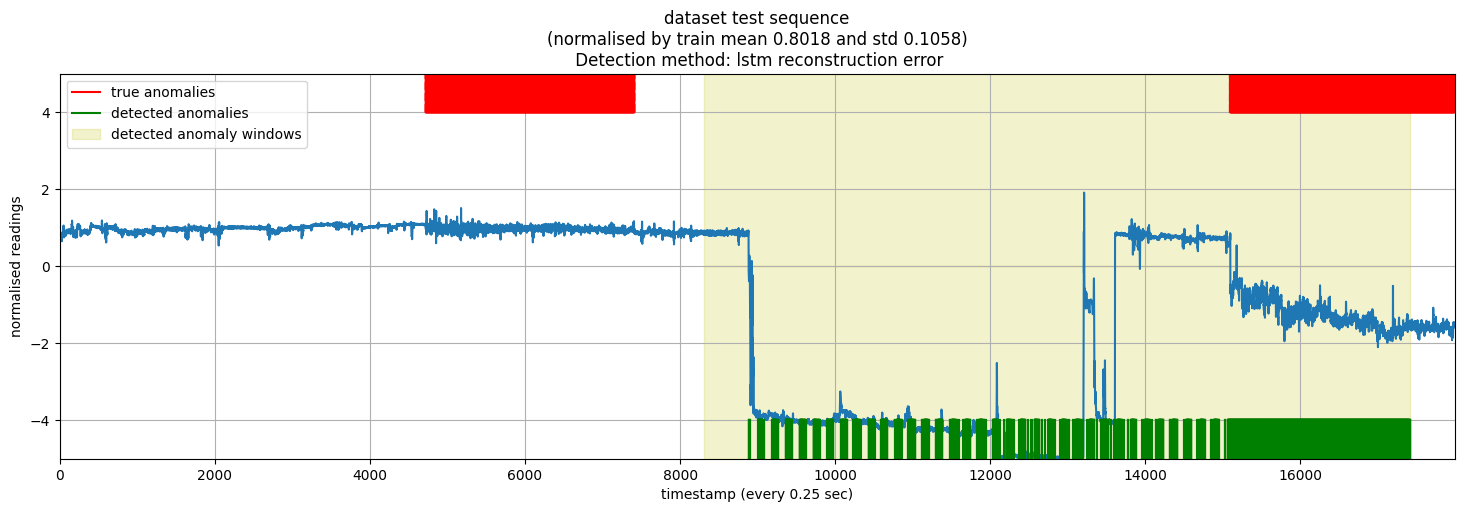

In [32]:
plot_detected_anomalies(idx_detection_augmented, 
                        interval=config['l_win']*config['l_seq']/2,
                        result=result, 
                        detection_method='lstm reconstruction error',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)